In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.5.2
0.5.2
4.1.2


In [2]:
# Resource exhausted error during training on GPU 막기위한 GPU 메모리 Grow https://github.com/tensorflow/tensorflow/issues/42257
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [3]:
import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# 1.데이타 준비와 확인

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

# 데이터를 읽어봅시다. 
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

len(train_data)

150000

#### columns
- id: The review id, provieded by Naver
- document: The actual review
- label: The sentiment class of the review. (0: negative, 1: positive)

#### Characteristics
- All reviews are shorter than 140 characters
- Each sentiment class is sampled equally (i.e., random guess yields 50% accuracy)
    - 100K negative reviews (originally reviews of ratings 1-4)
    - 100K positive reviews (originally reviews of ratings 9-10)
    - Neutral reviews (originally reviews of ratings 5-8) are excluded

# 2.데이터 로더 구성

In [5]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab('C:\mecab\mecab-ko-dic')
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data['document'] = train_data['document'].str.replace(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]"," ",regex=True)
    train_data = train_data.dropna(how = 'any') 
    
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'] = test_data['document'].str.replace(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]"," ",regex=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>','<UNUSED>'] + [key for key, _ in counter] 
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 함수 정의하기 
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    ret= [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]
    return ret
# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

Lookup tables

In [8]:
for i in range(4):
    label = y_train[i]
    encode = X_train[i]
    decode = get_decoded_sentence(encode, index_to_word)
    print(f'label: {label}\n\
        encode:{encode}\n\
        decode:{decode}')

label: 0
        encode:[27, 68, 921, 34, 218, 15, 28, 718]
        decode:더 빙 진짜 짜증 나 네요 목소리
label: 1
        encode:[993, 496, 527, 660, 4, 113, 1591, 48, 893, 971, 11, 39, 373]
        decode:포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
label: 0
        encode:[19, 195, 2]
        decode:재 <UNK>
label: 0
        encode:[8238, 149, 4358, 284, 86, 13, 5, 52, 3399]
        decode:이야기 구먼 솔직히 재미 없 다 평점 조정


In [9]:
X_train[0]

[27, 68, 921, 34, 218, 15, 28, 718]

# 3.모델 구성을 위한 데이터 분석 및 가공
- 3-1 데이터셋 내 문장 길이 분포
- 3-2 적절한 최대 문장 길이 지정
- 3-3 keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


## 3-1 데이터셋 내 문장 길이 분포

In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  14.03633682981893
문장길이 최대 :  105
문장길이 표준편차 :  11.64090268387157


In [11]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  37
전체 문장의 0.9352151900030203%가 maxlen 설정값 이내에 포함됩니다. 


In [12]:
len(index_to_word)

10000

In [13]:
import tensorflow as tf

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 100    # 그림과 같이 100차원의 워드 벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

output  = embedding(X_train)
print(output)


tf.Tensor(
[[[ 0.0371947  -0.01074461 -0.02605809 ...  0.0374108  -0.02418677
    0.00929258]
  [ 0.0371947  -0.01074461 -0.02605809 ...  0.0374108  -0.02418677
    0.00929258]
  [ 0.0371947  -0.01074461 -0.02605809 ...  0.0374108  -0.02418677
    0.00929258]
  ...
  [ 0.00637063  0.040758   -0.01461128 ... -0.02010452  0.03968715
    0.00318912]
  [-0.0126318   0.03482762  0.00560664 ... -0.01933839  0.04100937
    0.03435035]
  [-0.0006646   0.02058942  0.03897956 ...  0.02777828  0.03682936
    0.04516703]]

 [[ 0.0371947  -0.01074461 -0.02605809 ...  0.0374108  -0.02418677
    0.00929258]
  [ 0.0371947  -0.01074461 -0.02605809 ...  0.0374108  -0.02418677
    0.00929258]
  [ 0.0371947  -0.01074461 -0.02605809 ...  0.0374108  -0.02418677
    0.00929258]
  ...
  [-0.03237175 -0.0161968  -0.03352799 ... -0.03418093  0.03398076
   -0.02004669]
  [ 0.04056622  0.02100456 -0.03353654 ...  0.04313332 -0.02045064
    0.00741806]
  [-0.03269519  0.03479883  0.04577852 ...  0.03712089  0.0001

In [14]:
for i in range(4):
    label = y_train[i]
    encode = X_train[i]
    decode = get_decoded_sentence(encode, index_to_word)
    print(f'label: {label}\n\
        encode:{encode}\n\
        decode:{decode}')

label: 0
        encode:[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0  27  68 921  34 218  15  28
 718]
        decode:<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 진짜 짜증 나 네요 목소리
label: 1
        encode:[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  993  496  527  660
    4  113 1591   48  893  971   11   39  373]
        decode:<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 흠 포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
label: 0
        encode:[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  19 195
   2]
        decode:<PAD> <PAD> <PAD> <PAD> <PA

In [15]:
output[0] # 0번 문장에 대한 텐서

<tf.Tensor: shape=(37, 100), dtype=float32, numpy=
array([[ 0.0371947 , -0.01074461, -0.02605809, ...,  0.0374108 ,
        -0.02418677,  0.00929258],
       [ 0.0371947 , -0.01074461, -0.02605809, ...,  0.0374108 ,
        -0.02418677,  0.00929258],
       [ 0.0371947 , -0.01074461, -0.02605809, ...,  0.0374108 ,
        -0.02418677,  0.00929258],
       ...,
       [ 0.00637063,  0.040758  , -0.01461128, ..., -0.02010452,
         0.03968715,  0.00318912],
       [-0.0126318 ,  0.03482762,  0.00560664, ..., -0.01933839,
         0.04100937,  0.03435035],
       [-0.0006646 ,  0.02058942,  0.03897956, ...,  0.02777828,
         0.03682936,  0.04516703]], dtype=float32)>

# 4.모델 구성 및 validation set 구성

## 4-0 Tran Set와 Validation Set 분리

In [16]:
# X_train, y_train, X_test, y_test
# validation set 30000 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116182건
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

## 4-1 Embedding - RNN

### 4-1-1 모델 구성

In [33]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras import regularizers
from keras.layers import Dropout

vocab_size = len(word_to_index) 
word_vector_dim = 100  

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    input_shape=(None,)
                                    )) ##embeddings_regularizer=regularizers.l2(0.005)
model.add(Bidirectional(tf.keras.layers.LSTM(32)))  
model.add(Dropout(0.2))  
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 100)         1000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,034,577
Trainable params: 1,034,577
Non-trainable params: 0
____________________________________________

### 4-1-2 훈련 개시

In [34]:
def model_training(model, epochs):
    model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
                    
    epochs=epochs  

    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    return history

history = model_training(model,10)

Epoch 1/10
227/227 [==============================] - 6s 17ms/step - loss: 0.4452 - accuracy: 0.7932 - val_loss: 0.3488 - val_accuracy: 0.8473
Epoch 2/10
227/227 [==============================] - 3s 13ms/step - loss: 0.3320 - accuracy: 0.8569 - val_loss: 0.3404 - val_accuracy: 0.8503
Epoch 3/10
227/227 [==============================] - 3s 13ms/step - loss: 0.3058 - accuracy: 0.8705 - val_loss: 0.3402 - val_accuracy: 0.8510
Epoch 4/10
227/227 [==============================] - 3s 13ms/step - loss: 0.2817 - accuracy: 0.8809 - val_loss: 0.3454 - val_accuracy: 0.8514
Epoch 5/10
227/227 [==============================] - 3s 13ms/step - loss: 0.2586 - accuracy: 0.8901 - val_loss: 0.3516 - val_accuracy: 0.8489
Epoch 6/10
227/227 [==============================] - 3s 13ms/step - loss: 0.2374 - accuracy: 0.8998 - val_loss: 0.3750 - val_accuracy: 0.8501
Epoch 7/10
227/227 [==============================] - 3s 13ms/step - loss: 0.2185 - accuracy: 0.9087 - val_loss: 0.3926 - val_accuracy: 0.8435

In [35]:
weights = embedding.get_weights()
len(weights)

1

### 4-1-3 평가

In [36]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 7s - loss: 0.4593 - accuracy: 0.8414 - 7s/epoch - 5ms/step
[0.45929306745529175, 0.8414468169212341]


### 4-1-4 시각화 - loss

In [37]:
import matplotlib.pyplot as plt
def display_history(history, type = 'loss'):
    plt.figure(figsize=(8,4))
    history_dict = history.history
    acc = history_dict['accuracy']
    epochs = range(1, len(acc) + 1)   
    
    if type == 'loss':
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.ylabel('Loss')
    elif type == 'accuracy':
        acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy']
        plt.plot(epochs, acc, 'bo', label='Training accuracy')
        plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.ylabel('accuracy')
        
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()


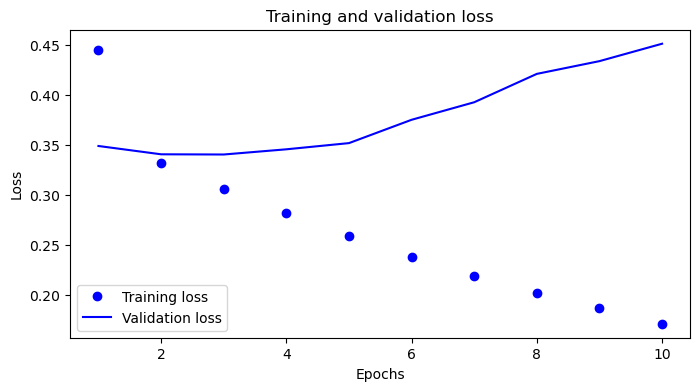

In [38]:
display_history(history,'loss')

### 4-1-4 시각화 - accuracy

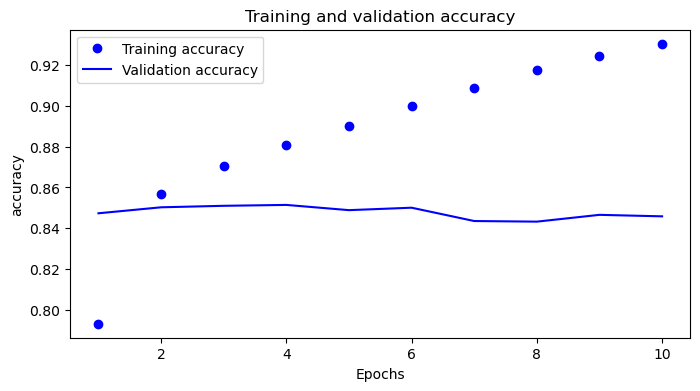

In [39]:
display_history(history,'accuracy')

### 4-1-5 Gensim 유사도 분석을 위해 파일 출력 ( 6-1을 위한 파일)

In [40]:
embedding_layer = model.layers[0]
embedding_layer.get_weights()[0]

array([[-1.9832397e-02, -3.6108911e-02,  4.8442971e-02, ...,
         9.5140786e-07, -1.6128270e-02, -6.4810686e-02],
       [-2.9524481e-02, -3.0612314e-02,  1.7071888e-04, ...,
        -5.4654367e-03,  3.1496767e-02, -2.9207850e-02],
       [ 1.3384308e-03, -5.8193840e-02, -4.3313902e-02, ...,
         2.2013234e-02,  2.3035123e-03,  1.0306459e-01],
       ...,
       [-4.1222926e-02, -9.5553562e-02, -6.4484075e-02, ...,
        -7.1210717e-03, -5.0805598e-02,  6.9484025e-02],
       [ 7.9877287e-02,  1.9444926e-01, -1.5828320e-01, ...,
         5.6132335e-02,  1.2191464e-01,  4.2551942e-02],
       [-7.2374530e-03,  2.8147414e-02,  3.3252865e-02, ...,
        -5.8593545e-03,  8.8442408e-02, -1.3217957e-01]], dtype=float32)

In [41]:
word_vector_dim

100

In [42]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]


# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = './data/word2vec_case_100.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


## 4-2 Embedding - CNN

### 4-2-1 모델 구성

In [43]:
from keras.layers import Dropout
vocab_size = len(word_to_index) 
word_vector_dim = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) #, embeddings_regularizer=regularizers.l2(0.01)
model.add(tf.keras.layers.Conv1D(16, 6, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 6, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 100)         1000000   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 16)          9616      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, None, 16)          1552      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 16)               

### 4-2-2 훈련 개시

In [44]:
history = model_training(model,10)

Epoch 1/10
227/227 [==============================] - 2s 8ms/step - loss: 0.5340 - accuracy: 0.7218 - val_loss: 0.4264 - val_accuracy: 0.7940
Epoch 2/10
227/227 [==============================] - 2s 8ms/step - loss: 0.4003 - accuracy: 0.8186 - val_loss: 0.4142 - val_accuracy: 0.8020
Epoch 3/10
227/227 [==============================] - 2s 8ms/step - loss: 0.3497 - accuracy: 0.8468 - val_loss: 0.4202 - val_accuracy: 0.8034
Epoch 4/10
227/227 [==============================] - 2s 7ms/step - loss: 0.2919 - accuracy: 0.8754 - val_loss: 0.4508 - val_accuracy: 0.7997
Epoch 5/10
227/227 [==============================] - 2s 8ms/step - loss: 0.2342 - accuracy: 0.9034 - val_loss: 0.4989 - val_accuracy: 0.7938
Epoch 6/10
227/227 [==============================] - 2s 8ms/step - loss: 0.1849 - accuracy: 0.9245 - val_loss: 0.5719 - val_accuracy: 0.7891
Epoch 7/10
227/227 [==============================] - 2s 8ms/step - loss: 0.1509 - accuracy: 0.9373 - val_loss: 0.6446 - val_accuracy: 0.7888
Epoch 

### 4-2-3 평가

In [45]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.8868 - accuracy: 0.7789 - 4s/epoch - 3ms/step
[0.8867570757865906, 0.7788920998573303]


### 4-2-4 시각화 - Loss

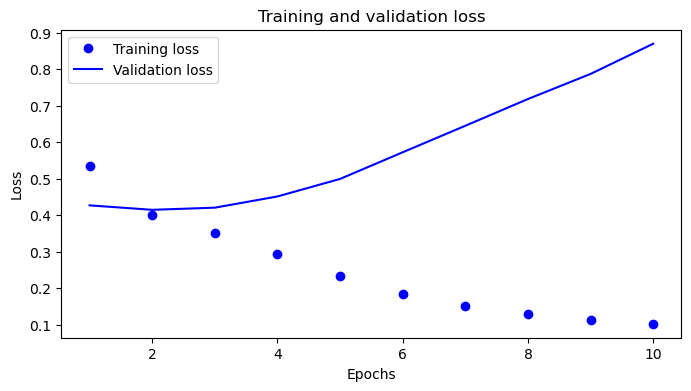

In [46]:
display_history(history,'loss')

### 4-2-4 시각화 - accuracy


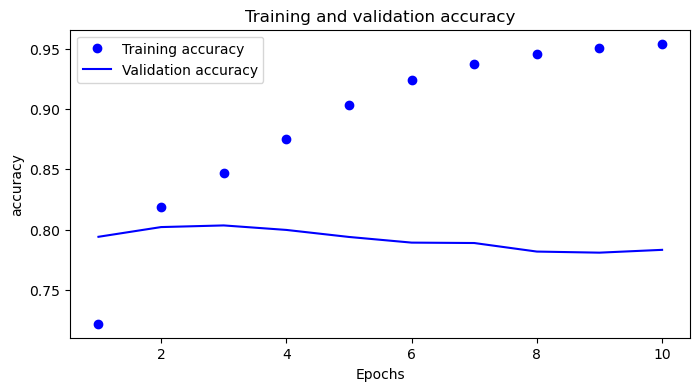

In [47]:
display_history(history,'accuracy')

## 4-3 Embedding - GlobalMaxPooling

### 4-3-1 모델 구성

In [48]:
from keras.layers import Dropout
vocab_size = len(word_to_index) 
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.  , embeddings_regularizer=regularizers.l2(0.02)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,) ))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 100)         1000000   
                                                                 
 global_max_pooling1d_2 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 808       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
____________________________________________

### 4-3-2 훈련 개시

In [50]:
history = model_training(model,10)

Epoch 1/10
227/227 [==============================] - 2s 7ms/step - loss: 0.5681 - accuracy: 0.7199 - val_loss: 0.4204 - val_accuracy: 0.8314
Epoch 2/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3678 - accuracy: 0.8491 - val_loss: 0.3498 - val_accuracy: 0.8485
Epoch 3/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3159 - accuracy: 0.8707 - val_loss: 0.3427 - val_accuracy: 0.8510
Epoch 4/10
227/227 [==============================] - 1s 7ms/step - loss: 0.2882 - accuracy: 0.8832 - val_loss: 0.3446 - val_accuracy: 0.8507
Epoch 5/10
227/227 [==============================] - 1s 6ms/step - loss: 0.2639 - accuracy: 0.8952 - val_loss: 0.3518 - val_accuracy: 0.8508
Epoch 6/10
227/227 [==============================] - 1s 6ms/step - loss: 0.2446 - accuracy: 0.9040 - val_loss: 0.3593 - val_accuracy: 0.8507
Epoch 7/10
227/227 [==============================] - 1s 6ms/step - loss: 0.2276 - accuracy: 0.9114 - val_loss: 0.3715 - val_accuracy: 0.8479
Epoch 

### 4-3-3 평가

In [51]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.4178 - accuracy: 0.8409 - 4s/epoch - 2ms/step
[0.4177599847316742, 0.8408771753311157]


### 4-3-4 시각화 - loss

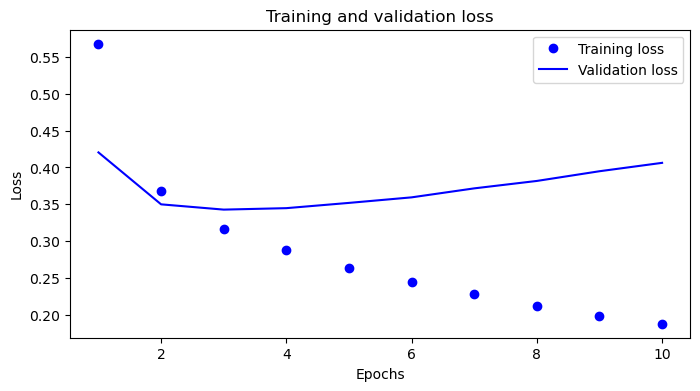

In [52]:
display_history(history,'loss')

### 4-3-4 시각화 - accuracy

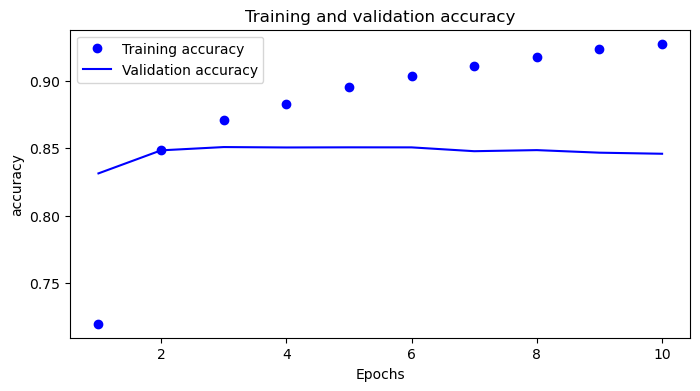

In [53]:
display_history(history,'accuracy')

# 5.Word2Vec PreTrained 임베딩 활용하여 성능개선

## 5-1 PreTrained Embedding Load

In [54]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = './Data/word2vec_ko.model'

word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

## 5-2 사전 학습 Embedding을 위한 matrix 만들기

In [55]:
vocab_size = len(word_to_index) 
word_vector_dim = 100  
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

## 5-3 모델 구성 - PreTrainEmbedding RNN

In [57]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.initializers import Constant
from keras.layers import Dropout

vocab_size = len(word_to_index) 
word_vector_dim = 100  # 워드 벡터의 차원 수 



model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                            word_vector_dim, 
                            embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                            #embeddings_regularizer=regularizers.l2(0.01),
                            input_length=maxlen, 
                            trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(Bidirectional(tf.keras.layers.LSTM(32)))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(Dropout(0.2)) 
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 37, 100)           1000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,034,577
Trainable params: 1,034,577
Non-trainable params: 0
____________________________________________

## 5-4 훈련 개시

In [58]:
history = model_training(model, 10)

Epoch 1/10
227/227 [==============================] - 6s 17ms/step - loss: 0.5296 - accuracy: 0.7268 - val_loss: 0.4314 - val_accuracy: 0.7996
Epoch 2/10
227/227 [==============================] - 3s 13ms/step - loss: 0.3971 - accuracy: 0.8216 - val_loss: 0.3754 - val_accuracy: 0.8318
Epoch 3/10
227/227 [==============================] - 3s 13ms/step - loss: 0.3503 - accuracy: 0.8477 - val_loss: 0.3483 - val_accuracy: 0.8486
Epoch 4/10
227/227 [==============================] - 3s 13ms/step - loss: 0.3235 - accuracy: 0.8614 - val_loss: 0.3418 - val_accuracy: 0.8509
Epoch 5/10
227/227 [==============================] - 3s 14ms/step - loss: 0.3029 - accuracy: 0.8720 - val_loss: 0.3388 - val_accuracy: 0.8508
Epoch 6/10
227/227 [==============================] - 3s 14ms/step - loss: 0.2879 - accuracy: 0.8792 - val_loss: 0.3364 - val_accuracy: 0.8559
Epoch 7/10
227/227 [==============================] - 3s 13ms/step - loss: 0.2737 - accuracy: 0.8855 - val_loss: 0.3363 - val_accuracy: 0.8562

## 5-5 평가

In [59]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 7s - loss: 0.3508 - accuracy: 0.8552 - 7s/epoch - 5ms/step
[0.35075053572654724, 0.8552393317222595]


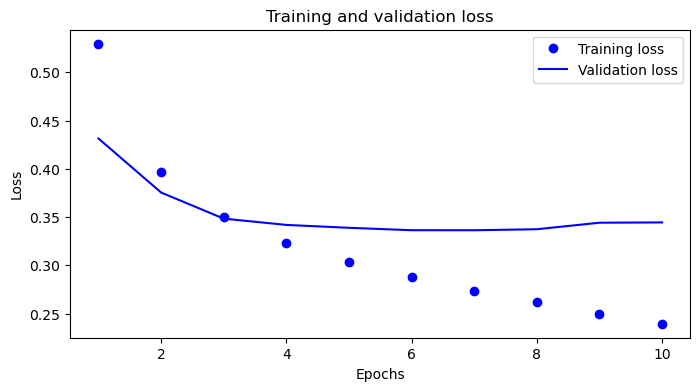

In [60]:
display_history(history,'loss')

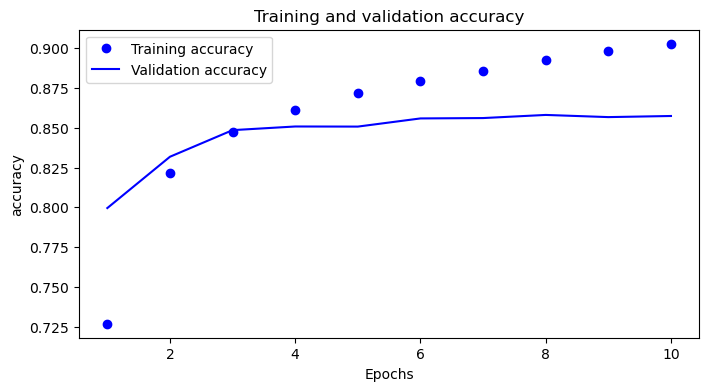

In [61]:
display_history(history,'accuracy')

## 5-6 Embeding 파라미터 저장

In [62]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]


# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = './data/word2vec_pretrained.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


# 6.학습된 Embedding 레이어 분석

## 6-1 Gensim을 이용한 자체 Train Embedding 레이어 분석

### 6-1-1 자체 Trained Embedding 데이타 load

In [63]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = './Data/word2vec_case_100.txt'
my_trained_vector = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path)


In [64]:
len(my_trained_vector)

9996

### 6-1-2 유사어 조회

In [6]:
my_trained_vector.similar_by_word('모험')


[('올까', 0.6313691139221191),
 ('구먼', 0.6098148226737976),
 ('이브', 0.6084216833114624),
 ('돼야', 0.6072012186050415),
 ('정돈', 0.6004087328910828),
 ('임금', 0.6003817915916443),
 ('지긋지긋', 0.5836395621299744),
 ('픽', 0.5811434388160706),
 ('겟', 0.5789611339569092),
 ('코드', 0.5768631100654602)]

### 6-1-3 Embedding Projector 파일 생성

In [9]:
my_trained_vector.save_word2vec_format('my_naver_w2v_100')


In [10]:
!python -m gensim.scripts.word2vec2tensor --input my_naver_w2v_100 --output my_naver_w2v_100

2023-04-18 03:47:25,010 - word2vec2tensor - INFO - running d:\Users\peunj\anaconda3\envs\tensor_gpu\lib\site-packages\gensim\scripts\word2vec2tensor.py --input my_naver_w2v_100 --output my_naver_w2v_100
2023-04-18 03:47:25,010 - keyedvectors - INFO - loading projection weights from my_naver_w2v_100
2023-04-18 03:47:25,569 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (9996, 100) matrix of type float32 from my_naver_w2v_100', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-04-18T03:47:25.542250', 'gensim': '4.1.2', 'python': '3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'load_word2vec_format'}
2023-04-18 03:47:26,134 - word2vec2tensor - INFO - 2D tensor file saved to my_naver_w2v_100_tensor.tsv
2023-04-18 03:47:26,134 - word2vec2tensor - INFO - Tensor metadata file saved to my_naver_w2v_100_metadata.tsv
2023-04-18 03:47:26,134 - word2vec2tensor - INFO - finished running word2vec2tensor.py


Embedding Projector  Display    
<img src='https://user-images.githubusercontent.com/95423215/233164437-99fe8840-84b4-4d53-9d97-5c93f1f08d6d.gif' width='50%' height='50%'>

## 6-2 PreTrained Embedding 분석 

### 6-2-1 PreTrained Embedding Data Load

In [2]:

from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = './Data/word2vec_pretrained.txt'
pre_trained_vector = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path)



### 6-2-2 유사어 조회

In [3]:
pre_trained_vector.similar_by_word('모험')

[('판타지', 0.6646401286125183),
 ('여정', 0.658145010471344),
 ('이야기', 0.6546163558959961),
 ('인생', 0.6381701827049255),
 ('미스터리', 0.6353504061698914),
 ('악당', 0.6329703330993652),
 ('결말', 0.6306099891662598),
 ('추억', 0.6290756464004517),
 ('배트맨', 0.6265950202941895),
 ('환상', 0.6210112571716309)]

### 6-2-3 Embedding Projector 파일 생성

In [3]:
pre_trained_vector.save_word2vec_format('predfined_w2v')

In [4]:
!python -m gensim.scripts.word2vec2tensor --input predfined_w2v --output predfined_w2v

2023-04-18 03:15:44,277 - word2vec2tensor - INFO - running d:\Users\peunj\anaconda3\envs\tensor_gpu\lib\site-packages\gensim\scripts\word2vec2tensor.py --input predfined_w2v --output predfined_w2v
2023-04-18 03:15:44,277 - keyedvectors - INFO - loading projection weights from predfined_w2v
2023-04-18 03:15:44,839 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (9996, 100) matrix of type float32 from predfined_w2v', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-04-18T03:15:44.810352', 'gensim': '4.1.2', 'python': '3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'load_word2vec_format'}
2023-04-18 03:15:45,374 - word2vec2tensor - INFO - 2D tensor file saved to predfined_w2v_tensor.tsv
2023-04-18 03:15:45,374 - word2vec2tensor - INFO - Tensor metadata file saved to predfined_w2v_metadata.tsv
2023-04-18 03:15:45,374 - word2vec2tensor - INFO - finished running word2vec2tensor.py


Embedding Projector로 본 __모험__키워드 유사어   
<img src='https://user-images.githubusercontent.com/95423215/232199522-6abd9361-3a81-4a60-ac18-5ebf11327d72.gif' width='50%' height='50%'>



In [ ]:
len(word_vectors.wv) # 302960


302960

## 6-3 자체 Trained Embedding vs Pretrained Embedding

In [15]:
my_trained_vector.similar_by_word('모험')

[('올까', 0.6313691139221191),
 ('구먼', 0.6098148226737976),
 ('이브', 0.6084216833114624),
 ('돼야', 0.6072012186050415),
 ('정돈', 0.6004087328910828),
 ('임금', 0.6003817915916443),
 ('지긋지긋', 0.5836395621299744),
 ('픽', 0.5811434388160706),
 ('겟', 0.5789611339569092),
 ('코드', 0.5768631100654602)]

In [16]:
pre_trained_vector.similar_by_word('모험')

[('판타지', 0.6646401286125183),
 ('여정', 0.658145010471344),
 ('이야기', 0.6546163558959961),
 ('인생', 0.6381701827049255),
 ('미스터리', 0.6353504061698914),
 ('악당', 0.6329703330993652),
 ('결말', 0.6306099891662598),
 ('추억', 0.6290756464004517),
 ('배트맨', 0.6265950202941895),
 ('환상', 0.6210112571716309)]

같은 단어에 대한 유사어 검색에서 자체 Train 데이타는 연관 없는 데이타를 가져온 반면, PreTrain 데이타는 유사 단어를 가져옴

In [17]:
sim_pre= pre_trained_vector.similarity('모험', '판타지')
sim_my = my_trained_vector.similarity('모험', '판타지')

print(f' 모험과 판타지 단어 사이에 유사도 비교 Pre: {sim_pre}  vs My : {sim_my}')

 모험과 판타지 단어 사이에 유사도 비교 Pre: 0.6646401882171631  vs My : 0.26084113121032715


모험과 판타지라는 단어 사이에 유사도를 체크해봐도 `Pre에서는 0.6으로 높은데 My에서는 0.2`로 낮은 것을 알수 있다. 

In [10]:
pre_trained_vector.distances('모험', '판타지')


array([0.88674116, 0.88315654, 0.9121122 ], dtype=float32)

In [9]:
my_trained_vector.distances('모험', '판타지')

array([1.1344638 , 1.2496071 , 0.97185373], dtype=float32)

모험과 판타지 두 단어사이에 벡터상의 거리도 차이가 있어서, Pre Train이 My Train보다 더 가까운 것을 볼 수있다. 

Embedding Projector상에 분석
PreTrained Data   
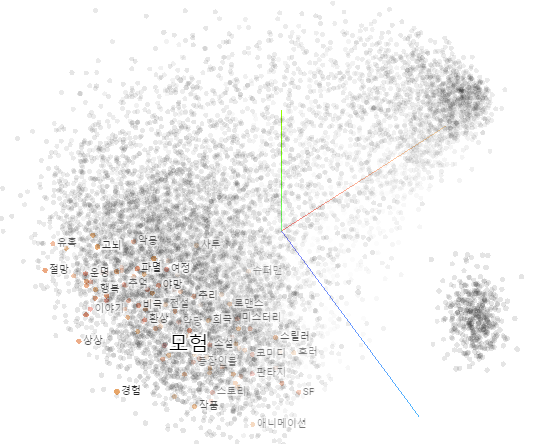
MyTrained Data   
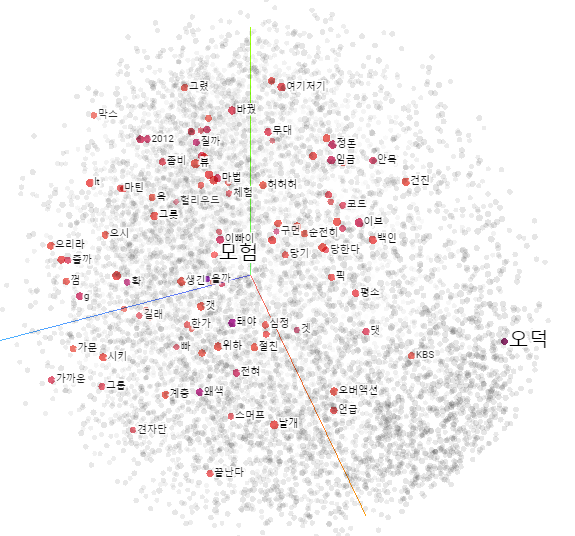

PreTrain 데이타는 3가지 군집으로 뚜렷하게 구분되는 모습을 보였다.   
3가지 군집은 각각 유의미한 단어, 의미없는 감탄사, 유행어등으로 유사한 언어간에 군집을 확인 할 수 있었다.    
반면, MyTrain 데이타는 뚜렷한 구분 없이 원형으로 분포되어있었다.    

PreTrain 데이타는 대량의 문장들을 미리 훈련받아 유사 의미간에 유의미한 군집이 형성된 상태이다.
그러나 My Train 테이타는 적은 수의 문장으로 학습되어 단어간에 유의미한 유사관계를 형성하지 못했다고 판단된다. 
Text데이타가 많지 않더라도 PreTrained Embedding 을 활용하면 더 유의미한 모델의 학습과 분석이 이루어질 것으로 보인다.


# 7.PreTrained Embedding을 통한 성능 향상

,Model,accuracy,loss
RNN,RNN,0.8414,0.4592
CNN,CNN,0.7788,0.8867
GlobalMaxPooling,GlobalMaxPooling,0.8408,0.4177
PreTrainEmbedding,PreTrainEmbedding RNN,0.8552,0.3507


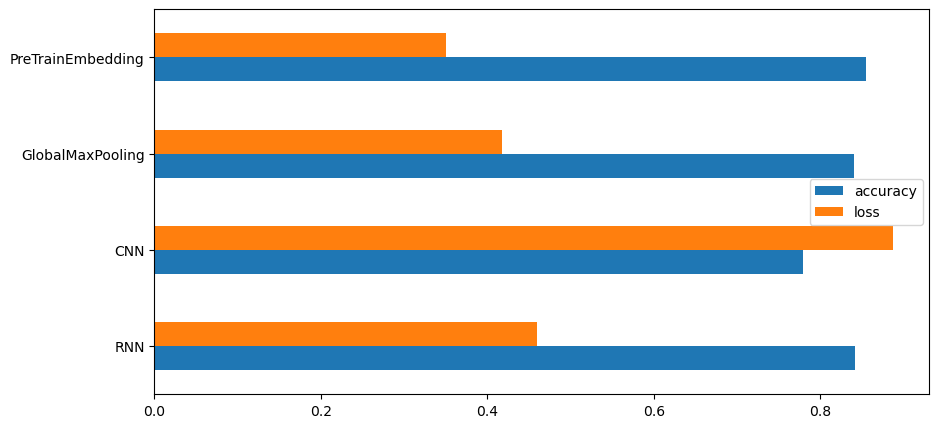

In [65]:
result_dict = {
    'Model': ['RNN', 'CNN', 'GlobalMaxPooling','PreTrainEmbedding RNN'],
    'accuracy': [0.8414,0.7788,0.8408,0.8552],
    'loss': [0.4592,0.8867,0.4177,0.3507]
}

result_df = pd.DataFrame(result_dict, index=['RNN', 'CNN', 'GlobalMaxPooling', 'PreTrainEmbedding'])
result_df.plot.barh(figsize=(10,5))
result_df


자체 Embedding으로 훈련했던 RNN, CNN, GlobalMaxPooling 모두 85% 정확도를 달성하지 못했는데, PreTrained Embedding을 사용하여 85% 정확도를 달성하였다.

# 8.회고

- 처음에 개념이 잘 잡히지 않았던 Embedding Layer에 대해서 자세히 알 수 있었다. 
- 자체 훈견된 Embedding에서 양질의 단어와 유사도에서 많은 아쉬움을 보였는데 PreTrained Ebedding에서는    
확실히 단어의 수준도 유사도도 품질이 높았다. 
- Embedding Projector에서 실제로 벡터 공간상에 위치된 단어들이 보니 이해하기 Embedding에 대한 개념을 잡는데
도움이 되었다. 


## 참고자료


https://soohee410.github.io/embedding_projector   
https://blog.naver.com/PostView.nhn?blogId=wonwone567&logNo=222154157176    
https://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html   
https://zzcojoa.tistory.com/83